In [1]:
# Libraries in the use
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

## Plotting according to the Industries. 

In [2]:
# US ETFs
US_SECTORS = [
  "XLK",   # Computer & Technology – Tech Select Sector SPDR
  "XLV",   # Medical – Health Care Select Sector SPDR
  "XLE",   # Oils/Energy – Energy Select Sector SPDR
  "XRT",   # Retail/Wholesale – SPDR S&P Retail (broad/equal-weight retail)
  "XLP",   # Consumer Staples – Consumer Staples Select Sector SPDR
  "IGV",   # Business Services – iShares Expanded Tech-Software (IT services/outsourcing proxy)
  "XLB",   # Basic Materials – Materials Select Sector SPDR
  "XLU",   # Utilities – Utilities Select Sector SPDR
  "ITA",   # Aerospace – iShares U.S. Aerospace & Defense
  "XLI",   # Industrial Products – Industrials Select Sector SPDR
  "XLY",   # Consumer Discretionary – Consumer Discretionary Select Sector SPDR
  "ITB",   # Construction – iShares U.S. Home Construction
  "IYT",   # Transportation – iShares U.S. Transportation
  "CARZ"   # Auto/Tires/Trucks – First Trust NASDAQ Global Auto (autos proxy)
]

In [3]:
# Japan ETFs 
JP_SECTORS = [
  "1625.T", # Computer & Technology – Electric Appliances & Precision Instruments (tech hardware proxy)
  "1621.T", # Medical – Pharmaceutical (narrower than US health care)
  "1618.T", # Oils/Energy – Energy Resources
  "1629.T", # Retail/Wholesale – Commercial & Wholesale Trade
  "1617.T", # Consumer Staples – Foods (closest to staples)
  "1626.T", # Business Services – IT & Services, Others
  "1620.T", # Basic Materials – Raw Materials & Chemicals
  "1627.T", # Utilities – Electric Power & Gas
  "1624.T", # Aerospace – Machinery (closest domestic proxy for aerospace/defense supply chain)
  "1623.T", # Industrial Products – Steel & Nonferrous Metals (core industrial inputs)
  "1630.T", # Consumer Discretionary – Retail Trade (broad JP discretionary exposure)
  "1619.T", # Construction – Construction & Materials
  "1628.T", # Transportation – Transportation & Logistics
  "1622.T"  # Auto/Tires/Trucks – Automobiles & Transportation Equipment
]

In [22]:
# Benchmarks
US_BENCH = "SPY"      # S&P 500 ETF
JP_BENCH = "1321.T"   # Nikkei 225 ETF

# Time periods
BASELINE = "2020-01-02"  # Pre-COVID reference
CRASH = ("2020-02-19", "2020-03-23")      # Market (~1 month)
RECOVERY = ("2020-03-24", "2020-12-31")   # Initial recovery (~9 months)
POSTCOVID = ("2021-01-01", str(date.today()))  # Post-vaccine era

START_DATE = "2020-01-01"
END_DATE = "2022-01-01"

print(f"Analysis Configuration:")
print(f"  Baseline: {BASELINE}")
print(f"  Crash period: {CRASH[0]} to {CRASH[1]}")
print(f"  Recovery period: {RECOVERY[0]} to {RECOVERY[1]}")
print(f"  Post-COVID period: {POSTCOVID[0]} to {POSTCOVID[1]}")
print(f"\n  US Sectors: {len(US_SECTORS)}")
print(f"  Japan Sectors: {len(JP_SECTORS)}")


Analysis Configuration:
  Baseline: 2020-01-02
  Crash period: 2020-02-19 to 2020-03-23
  Recovery period: 2020-03-24 to 2020-12-31
  Post-COVID period: 2021-01-01 to 2025-10-28

  US Sectors: 14
  Japan Sectors: 14


### Making Helper Functions


In [23]:
def download_data(tickers, start=START_DATE, end=END_DATE):
    """
    Download adjusted close prices for all tickers.
    
    Args:
        tickers: List of ticker symbols
        start: Start date
        end: End date
    
    Returns:
        DataFrame with adjusted close prices
    """
    print(f"📥 Downloading {len(tickers)} tickers from {start} to {end}...")
    df = yf.download(tickers, start=start, end=end, auto_adjust=False, 
                     progress=False)["Adj Close"]
    
    # Handle single ticker case
    if isinstance(df, pd.Series):
        df = df.to_frame()
    
    # Drop columns with all NaN
    df = df.dropna(how="all", axis=1)
    print(f"✅ Successfully downloaded {len(df.columns)} tickers\n")
    return df


In [24]:
def calculate_relative_performance(sectors_df, benchmark_series, baseline_date):
    """
    Calculate sector performance RELATIVE to benchmark, normalized to 100 at baseline.
    
    Steps:
    1. Divide each sector by benchmark (sector/benchmark ratio)
    2. Normalize to 100 at baseline date
    
    Args:
        sectors_df: DataFrame of sector prices
        benchmark_series: Series of benchmark prices
        baseline_date: Date to normalize to 100
    
    Returns:
        Tuple of (relative_normalized DataFrame, actual baseline date used)
    """
    # Find nearest trading day to baseline
    baseline_idx = sectors_df.index.get_indexer(
        [pd.to_datetime(baseline_date)], method="nearest"
    )[0]
    baseline_used = sectors_df.index[baseline_idx]
    
    # Calculate relative performance (sector / benchmark)
    relative = sectors_df.div(benchmark_series, axis=0)
    
    # Normalize to 100 at baseline
    baseline_values = relative.iloc[baseline_idx]
    relative_normalized = (relative / baseline_values) * 100.0
    
    return relative_normalized, baseline_used

# %% [markdown]
# ## 5. Analysis Metric Functions

# %%
def slice_period(df, start_date, end_date):
    """Extract data for a specific time period."""
    mask = (df.index >= pd.to_datetime(start_date)) & \
           (df.index <= pd.to_datetime(end_date))
    return df.loc[mask]

def calculate_max_drawdown(series):
    """
    Calculate maximum drawdown and when it occurred.
    
    Drawdown = how far below the previous peak
    """
    cummax = series.cummax()
    drawdown = (series / cummax) - 1
    max_dd = drawdown.min()
    trough_date = drawdown.idxmin()
    return max_dd, trough_date

def calculate_recovery_days(series, baseline_date, threshold=100.0):
    """
    Calculate days to recover to baseline (100 = parity with benchmark).
    Returns NaN if never recovered.
    """
    post_baseline = series[series.index >= baseline_date]
    recovered = post_baseline[post_baseline >= threshold]
    
    if recovered.empty:
        return np.nan
    
    recovery_date = recovered.index[0]
    days = (recovery_date - baseline_date).days
    return days

def calculate_period_return(series):
    """Calculate cumulative return over the series period."""
    if len(series) < 2:
        return np.nan
    return (series.iloc[-1] / series.iloc[0]) - 1

# %% [markdown]
# ## 6. Comprehensive Summary Statistics

# %%
def generate_summary(relative_norm, baseline_date, crash_period, recovery_period, postcovid_period):
    """
    Generate comprehensive summary statistics for each sector.
    
    Metrics:
    - Max drawdown during crash (worst point relative to peak)
    - Days to recover to baseline (100 = benchmark parity)
    - Returns for each period
    - Current relative index level
    """
    # Slice data by period
    crash_data = slice_period(relative_norm, *crash_period)
    recovery_data = slice_period(relative_norm, *recovery_period)
    postcovid_data = slice_period(relative_norm, *postcovid_period)
    
    results = []
    
    for ticker in relative_norm.columns:
        series_full = relative_norm[ticker].dropna()
        series_crash = crash_data[ticker].dropna()
        series_recovery = recovery_data[ticker].dropna()
        series_postcovid = postcovid_data[ticker].dropna()
        
        # Calculate metrics
        max_dd, trough_date = calculate_max_drawdown(series_crash) \
            if not series_crash.empty else (np.nan, pd.NaT)
        
        recovery_days = calculate_recovery_days(series_full, baseline_date)
        
        ret_crash = calculate_period_return(series_crash)
        ret_recovery = calculate_period_return(series_recovery)
        ret_postcovid = calculate_period_return(series_postcovid)
        ret_total = calculate_period_return(series_full)
        
        results.append({
            "ticker": ticker,
            "max_drawdown_crash": max_dd,
            "trough_date": trough_date.date() if pd.notna(trough_date) else None,
            "recovery_days": recovery_days,
            "return_crash": ret_crash,
            "return_recovery": ret_recovery,
            "return_postcovid": ret_postcovid,
            "return_total": ret_total,
            "current_relative_index": series_full.iloc[-1] if not series_full.empty else np.nan
        })
    
    return pd.DataFrame(results)


📊 Analyzing US Market

📥 Downloading 15 tickers from 2020-01-01 to 2022-01-01...
✅ Successfully downloaded 15 tickers

Benchmark: SPY
Sectors analyzed: 14

📅 Baseline date used: 2020-01-02

🔴 US SECTORS MOST HURT (relative to S&P 500)



,ticker,max_drawdown_crash,recovery_days,return_crash
2,XLE,-38.55%,0,-33.72%
11,ITB,-33.35%,0,-26.97%
8,ITA,-26.89%,0,-24.87%
13,CARZ,-18.64%,0,-11.87%
3,XRT,-15.81%,0,-9.16%
9,XLI,-12.99%,0,-11.86%
7,XLU,-12.56%,0,-2.49%


🟢 US SECTORS MOST BENEFITED (relative to S&P 500)



,ticker,return_recovery,return_postcovid,return_total
13,CARZ,42.30%,-9.81%,19.29%
3,XRT,40.11%,10.61%,35.12%
11,ITB,28.05%,16.41%,25.33%
5,IGV,11.60%,-12.23%,11.73%
6,XLB,10.12%,-1.41%,2.93%
10,XLY,8.53%,-1.14%,8.59%
0,XLK,8.37%,4.96%,25.87%


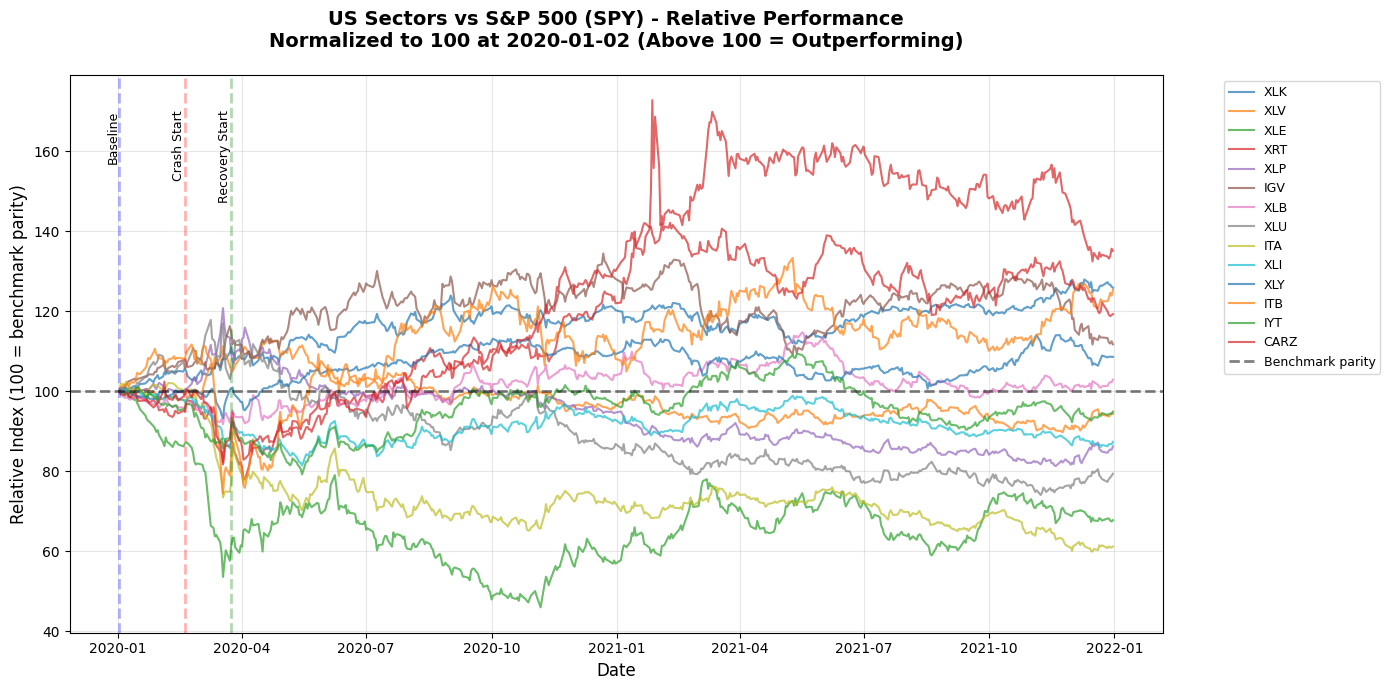

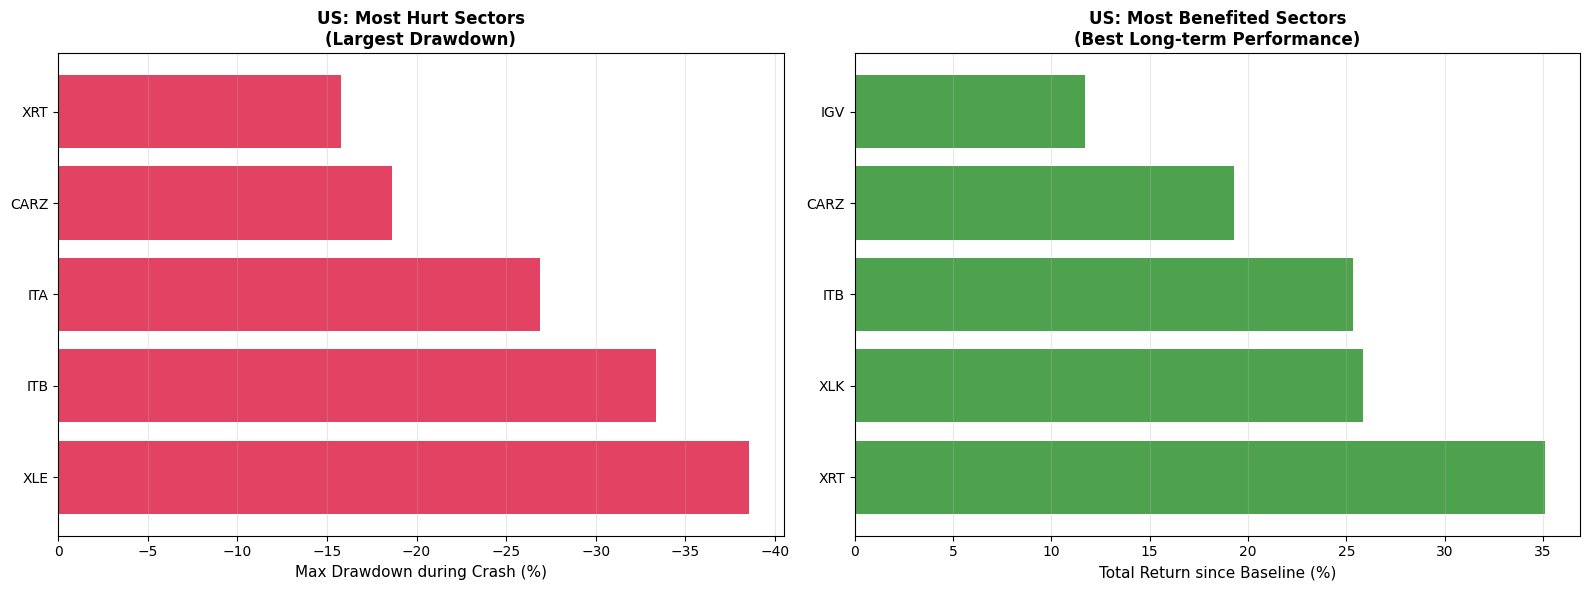


📊 Analyzing Japan Market

📥 Downloading 15 tickers from 2020-01-01 to 2022-01-01...
✅ Successfully downloaded 15 tickers

Benchmark: 1321.T
Sectors analyzed: 14

📅 Baseline date used: 2020-01-06

🔴 JAPAN SECTORS MOST HURT (relative to Nikkei 225)



,ticker,max_drawdown_crash,recovery_days,return_crash
2,1618.T,-12.20%,0,-7.14%
9,1623.T,-11.29%,0,-6.69%
10,1630.T,-8.51%,0,16.11%
5,1626.T,-8.44%,0,12.69%
8,1624.T,-7.38%,0,4.70%
7,1627.T,-4.16%,0,23.15%
11,1619.T,-4.12%,0,-0.16%


🟢 JAPAN SECTORS MOST BENEFITED (relative to Nikkei 225)



,ticker,return_recovery,return_postcovid,return_total
0,1625.T,6.10%,17.21%,22.76%
8,1624.T,3.13%,0.89%,0.31%
5,1626.T,-2.32%,-2.88%,-1.82%
9,1623.T,-6.52%,13.52%,-13.05%
6,1620.T,-9.13%,-3.13%,-11.99%
13,1622.T,-13.33%,20.44%,1.12%
11,1619.T,-13.76%,5.89%,-16.12%


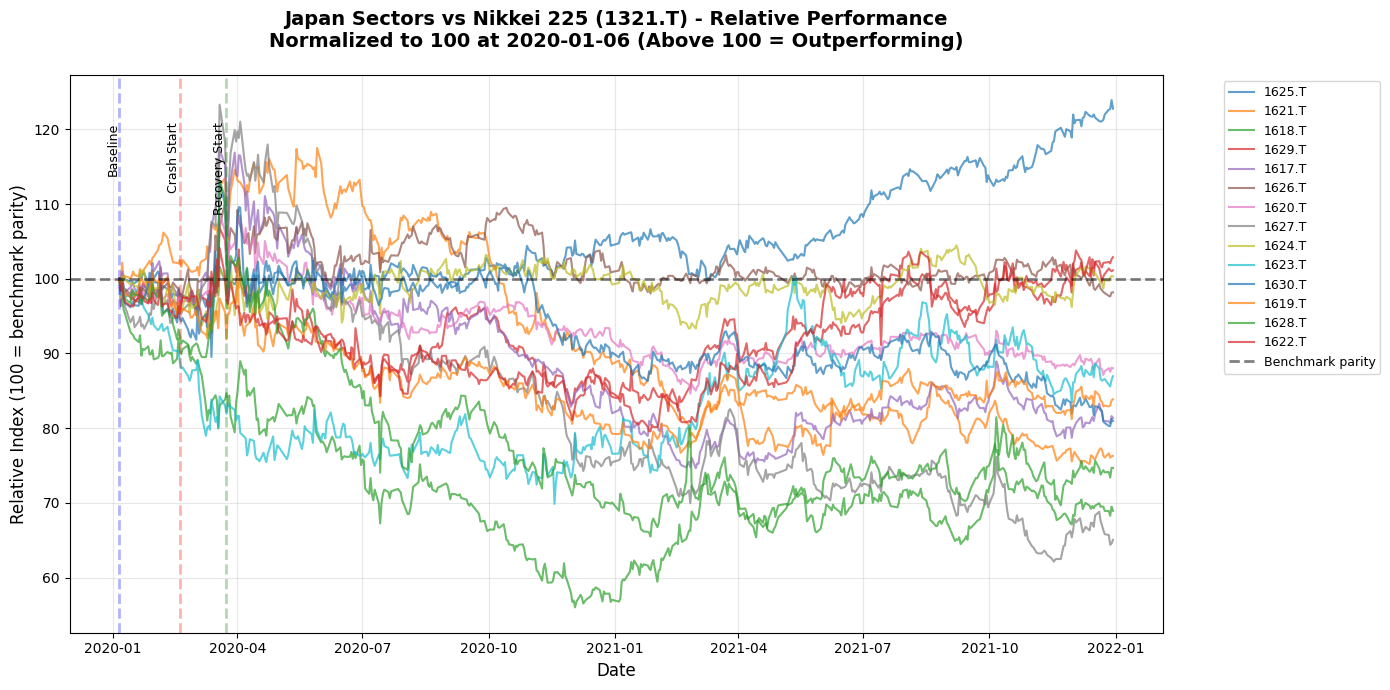

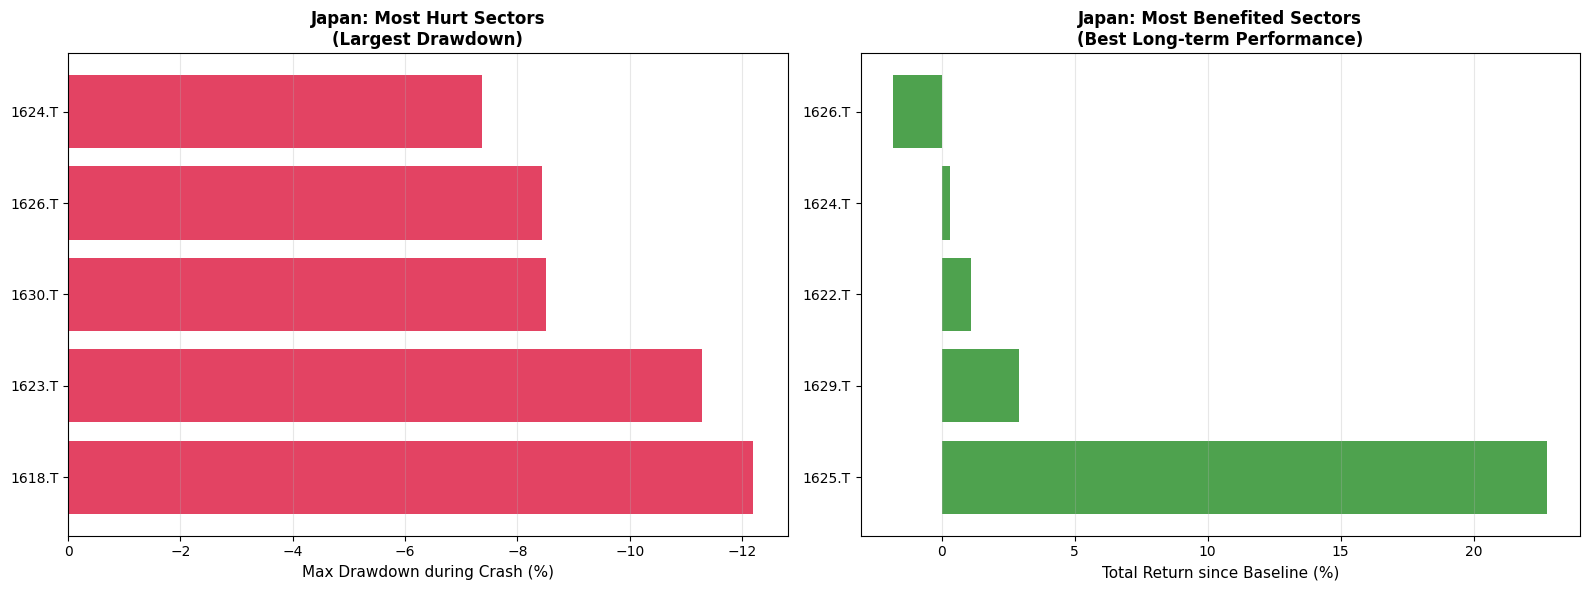

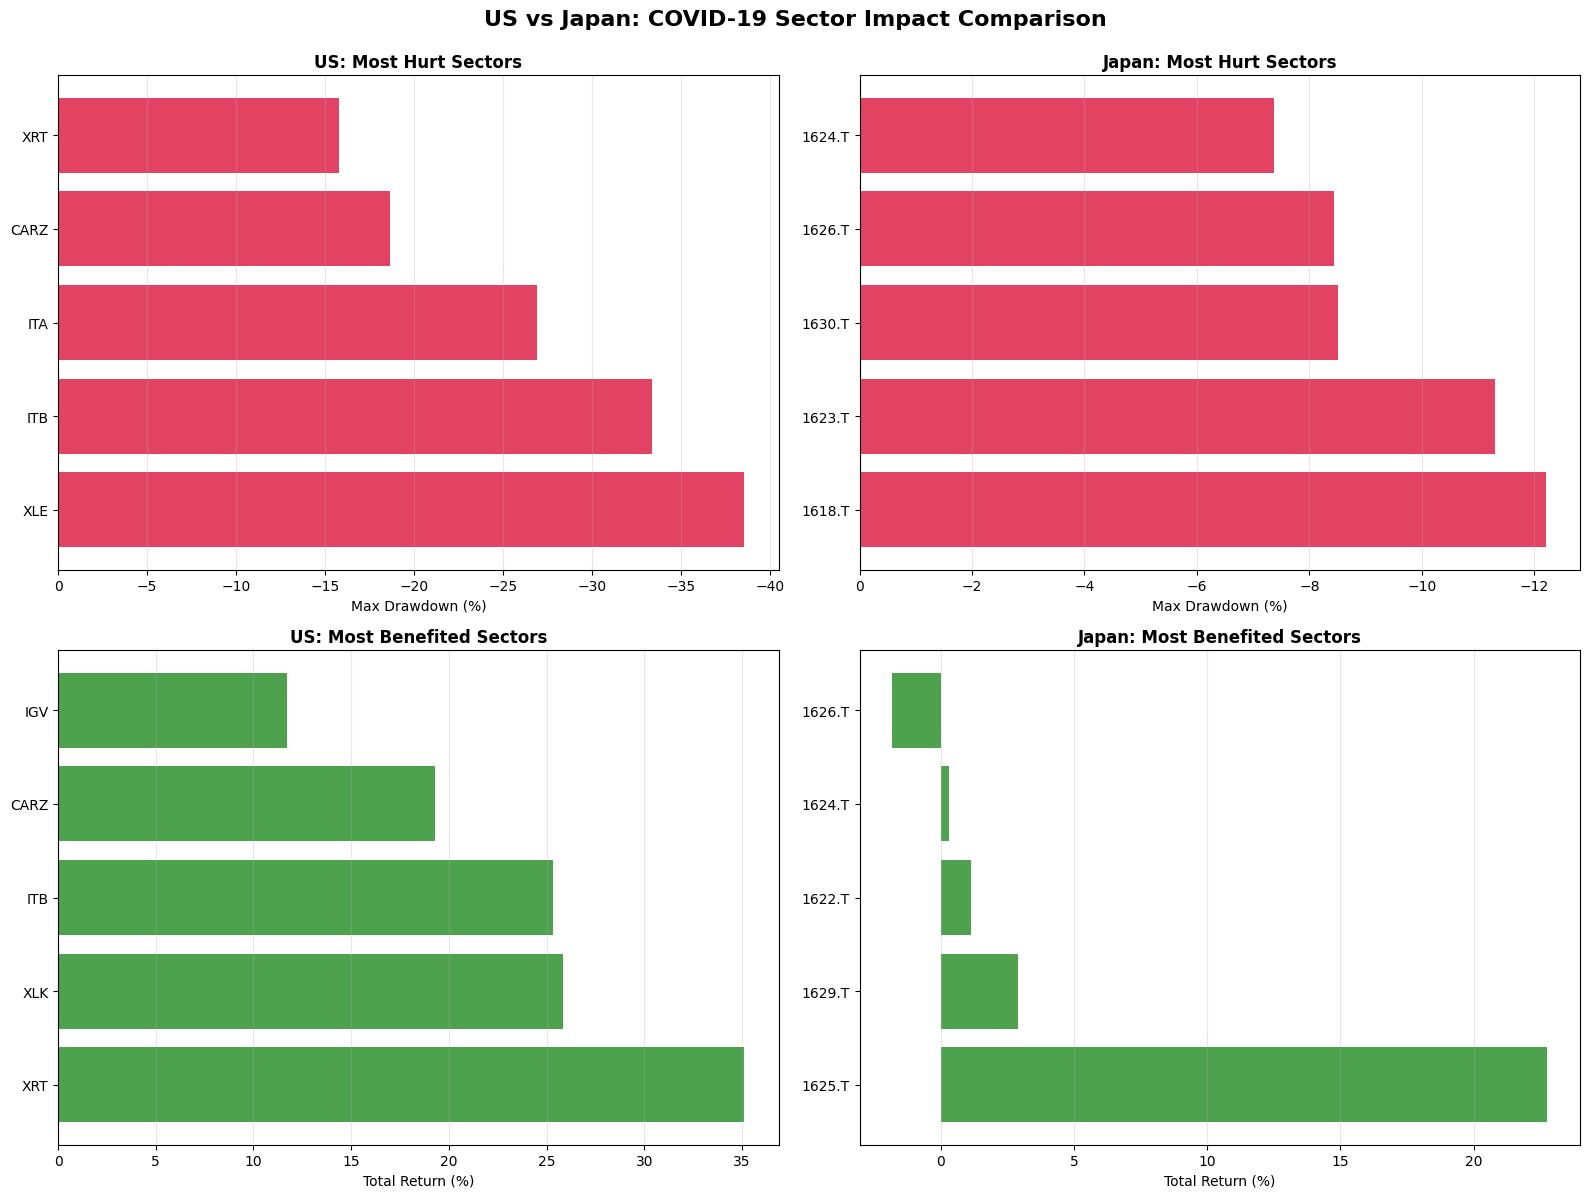

✅ Saved: us_covid_analysis.csv
✅ Saved: japan_covid_analysis.csv
KEY INSIGHTS SUMMARY

🇺🇸 UNITED STATES:
  • Worst performer: XLE
    Max drawdown: -38.55%
  • Best performer: XRT
    Total return: 35.12%

🇯🇵 JAPAN:
  • Worst performer: 1618.T
    Max drawdown: -12.20%
  • Best performer: 1625.T
    Total return: 22.76%



In [25]:
def analyze_market(name, sector_tickers, benchmark_ticker):
    """
    Complete analysis pipeline for one market (US or Japan).
    
    Returns:
        Tuple of (relative_normalized_df, baseline_date_used, summary_df)
    """
    print(f"\n{'='*70}")
    print(f"📊 Analyzing {name} Market")
    print(f"{'='*70}\n")
    
    # Download data
    all_tickers = [benchmark_ticker] + sector_tickers
    raw_data = download_data(all_tickers)
    
    if raw_data.empty or benchmark_ticker not in raw_data.columns:
        print(f"❌ ERROR: No data for {name}. Check tickers and internet connection.")
        return None, None, None
    
    # Separate benchmark and sectors
    benchmark = raw_data[benchmark_ticker]
    sectors = raw_data[sector_tickers].dropna(axis=1, how="all")
    
    print(f"Benchmark: {benchmark_ticker}")
    print(f"Sectors analyzed: {len(sectors.columns)}\n")
    
    # Calculate relative performance
    rel_norm, baseline_used = calculate_relative_performance(
        sectors, benchmark, BASELINE
    )
    
    print(f"📅 Baseline date used: {baseline_used.date()}\n")
    
    # Generate summary statistics
    summary = generate_summary(
        rel_norm, baseline_used, CRASH, RECOVERY, POSTCOVID
    )
    
    return rel_norm, baseline_used, summary

# %% [markdown]
# ## 8. Visualization Functions

# %%
def plot_relative_performance(rel_norm, baseline_date, name, benchmark_name):
    """
    Create visualization of relative sector performance over time.
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot all sectors with transparency
    for col in rel_norm.columns:
        ax.plot(rel_norm.index, rel_norm[col], linewidth=1.5, alpha=0.7, label=col)
    
    # Add reference line at 100 (parity with benchmark)
    ax.axhline(y=100, color='black', linestyle='--', linewidth=2, alpha=0.5, 
               label='Benchmark parity', zorder=10)
    
    # Mark key dates
    ax.axvline(baseline_date, color='blue', linestyle='--', alpha=0.3, linewidth=2)
    ax.text(baseline_date, ax.get_ylim()[1]*0.95, 'Baseline', 
            rotation=90, va='top', ha='right', fontsize=9)
    
    ax.axvline(pd.to_datetime(CRASH[0]), color='red', linestyle='--', alpha=0.3, linewidth=2)
    ax.text(pd.to_datetime(CRASH[0]), ax.get_ylim()[1]*0.95, 'Crash Start', 
            rotation=90, va='top', ha='right', fontsize=9)
    
    ax.axvline(pd.to_datetime(RECOVERY[0]), color='green', linestyle='--', alpha=0.3, linewidth=2)
    ax.text(pd.to_datetime(RECOVERY[0]), ax.get_ylim()[1]*0.95, 'Recovery Start', 
            rotation=90, va='top', ha='right', fontsize=9)
    
    # Labels and formatting
    ax.set_title(
        f"{name} Sectors vs {benchmark_name} - Relative Performance\n"
        f"Normalized to 100 at {baseline_date.date()} (Above 100 = Outperforming)",
        fontsize=14, fontweight='bold', pad=20
    )
    ax.set_ylabel("Relative Index (100 = benchmark parity)", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_top_hurt_and_benefited(summary, name):
    """
    Create bar charts showing most hurt and most benefited sectors.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Most Hurt (worst drawdown)
    hurt = summary.nsmallest(5, 'max_drawdown_crash')
    axes[0].barh(hurt['ticker'], hurt['max_drawdown_crash'] * 100, 
                 color='crimson', alpha=0.8)
    axes[0].set_xlabel('Max Drawdown during Crash (%)', fontsize=11)
    axes[0].set_title(f'{name}: Most Hurt Sectors\n(Largest Drawdown)', 
                      fontweight='bold', fontsize=12)
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_xaxis()
    
    # Most Benefited (best total return)
    benefited = summary.nlargest(5, 'return_total')
    axes[1].barh(benefited['ticker'], benefited['return_total'] * 100, 
                 color='forestgreen', alpha=0.8)
    axes[1].set_xlabel('Total Return since Baseline (%)', fontsize=11)
    axes[1].set_title(f'{name}: Most Benefited Sectors\n(Best Long-term Performance)', 
                      fontweight='bold', fontsize=12)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 9. Run Analysis for US Market

# %%
us_rel_norm, us_baseline, us_summary = analyze_market("US", US_SECTORS, US_BENCH)

# %% [markdown]
# ### US: Most Hurt Sectors

# %%
if us_summary is not None:
    hurt_us = us_summary.sort_values(['max_drawdown_crash', 'recovery_days'], 
                                     ascending=[True, False])
    print("🔴 US SECTORS MOST HURT (relative to S&P 500)\n")
    display(hurt_us[['ticker', 'max_drawdown_crash', 'recovery_days', 
                     'return_crash']].head(7).style.format({
        'max_drawdown_crash': '{:.2%}',
        'recovery_days': '{:.0f}',
        'return_crash': '{:.2%}'
    }).background_gradient(cmap='Reds', subset=['max_drawdown_crash']))

# %% [markdown]
# ### US: Most Benefited Sectors

# %%
if us_summary is not None:
    benefited_us = us_summary.sort_values(['return_recovery', 'return_postcovid', 'return_total'],
                                          ascending=[False, False, False])
    print("🟢 US SECTORS MOST BENEFITED (relative to S&P 500)\n")
    display(benefited_us[['ticker', 'return_recovery', 'return_postcovid', 
                          'return_total']].head(7).style.format({
        'return_recovery': '{:.2%}',
        'return_postcovid': '{:.2%}',
        'return_total': '{:.2%}'
    }).background_gradient(cmap='Greens', subset=['return_total']))

# %% [markdown]
# ### US: Visualizations

# %%
if us_rel_norm is not None:
    plot_relative_performance(us_rel_norm, us_baseline, "US", "S&P 500 (SPY)")
    plot_top_hurt_and_benefited(us_summary, "US")

# %% [markdown]
# ## 10. Run Analysis for Japan Market

# %%
jp_rel_norm, jp_baseline, jp_summary = analyze_market("Japan", JP_SECTORS, JP_BENCH)

# %% [markdown]
# ### Japan: Most Hurt Sectors

# %%
if jp_summary is not None:
    hurt_jp = jp_summary.sort_values(['max_drawdown_crash', 'recovery_days'], 
                                     ascending=[True, False])
    print("🔴 JAPAN SECTORS MOST HURT (relative to Nikkei 225)\n")
    display(hurt_jp[['ticker', 'max_drawdown_crash', 'recovery_days', 
                     'return_crash']].head(7).style.format({
        'max_drawdown_crash': '{:.2%}',
        'recovery_days': '{:.0f}',
        'return_crash': '{:.2%}'
    }).background_gradient(cmap='Reds', subset=['max_drawdown_crash']))

# %% [markdown]
# ### Japan: Most Benefited Sectors

# %%
if jp_summary is not None:
    benefited_jp = jp_summary.sort_values(['return_recovery', 'return_postcovid', 'return_total'],
                                          ascending=[False, False, False])
    print("🟢 JAPAN SECTORS MOST BENEFITED (relative to Nikkei 225)\n")
    display(benefited_jp[['ticker', 'return_recovery', 'return_postcovid', 
                          'return_total']].head(7).style.format({
        'return_recovery': '{:.2%}',
        'return_postcovid': '{:.2%}',
        'return_total': '{:.2%}'
    }).background_gradient(cmap='Greens', subset=['return_total']))

# %% [markdown]
# ### Japan: Visualizations

# %%
if jp_rel_norm is not None:
    plot_relative_performance(jp_rel_norm, jp_baseline, "Japan", "Nikkei 225 (1321.T)")
    plot_top_hurt_and_benefited(jp_summary, "Japan")

# %% [markdown]
# ## 11. US vs Japan Comparison

# %%
if us_summary is not None and jp_summary is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # US - Most Hurt
    us_hurt = us_summary.nsmallest(5, 'max_drawdown_crash')
    axes[0, 0].barh(us_hurt['ticker'], us_hurt['max_drawdown_crash'] * 100, 
                    color='crimson', alpha=0.8)
    axes[0, 0].set_xlabel('Max Drawdown (%)')
    axes[0, 0].set_title('US: Most Hurt Sectors', fontweight='bold', fontsize=12)
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].invert_xaxis()
    
    # Japan - Most Hurt
    jp_hurt = jp_summary.nsmallest(5, 'max_drawdown_crash')
    axes[0, 1].barh(jp_hurt['ticker'], jp_hurt['max_drawdown_crash'] * 100, 
                    color='crimson', alpha=0.8)
    axes[0, 1].set_xlabel('Max Drawdown (%)')
    axes[0, 1].set_title('Japan: Most Hurt Sectors', fontweight='bold', fontsize=12)
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_xaxis()
    
    # US - Most Benefited
    us_benefit = us_summary.nlargest(5, 'return_total')
    axes[1, 0].barh(us_benefit['ticker'], us_benefit['return_total'] * 100, 
                    color='forestgreen', alpha=0.8)
    axes[1, 0].set_xlabel('Total Return (%)')
    axes[1, 0].set_title('US: Most Benefited Sectors', fontweight='bold', fontsize=12)
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Japan - Most Benefited
    jp_benefit = jp_summary.nlargest(5, 'return_total')
    axes[1, 1].barh(jp_benefit['ticker'], jp_benefit['return_total'] * 100, 
                    color='forestgreen', alpha=0.8)
    axes[1, 1].set_xlabel('Total Return (%)')
    axes[1, 1].set_title('Japan: Most Benefited Sectors', fontweight='bold', fontsize=12)
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.suptitle('US vs Japan: COVID-19 Sector Impact Comparison', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 12. Save Results to CSV

# %%
if us_summary is not None:
    us_summary.to_csv('us_covid_analysis.csv', index=False)
    print("✅ Saved: us_covid_analysis.csv")

if jp_summary is not None:
    jp_summary.to_csv('japan_covid_analysis.csv', index=False)
    print("✅ Saved: japan_covid_analysis.csv")

# %% [markdown]
# ## 13. Key Insights Summary

# %%
if us_summary is not None and jp_summary is not None:
    print("="*70)
    print("KEY INSIGHTS SUMMARY")
    print("="*70)
    
    print("\n🇺🇸 UNITED STATES:")
    print(f"  • Worst performer: {us_summary.loc[us_summary['max_drawdown_crash'].idxmin(), 'ticker']}")
    print(f"    Max drawdown: {us_summary['max_drawdown_crash'].min():.2%}")
    print(f"  • Best performer: {us_summary.loc[us_summary['return_total'].idxmax(), 'ticker']}")
    print(f"    Total return: {us_summary['return_total'].max():.2%}")
    
    print("\n🇯🇵 JAPAN:")
    print(f"  • Worst performer: {jp_summary.loc[jp_summary['max_drawdown_crash'].idxmin(), 'ticker']}")
    print(f"    Max drawdown: {jp_summary['max_drawdown_crash'].min():.2%}")
    print(f"  • Best performer: {jp_summary.loc[jp_summary['return_total'].idxmax(), 'ticker']}")
    print(f"    Total return: {jp_summary['return_total'].max():.2%}")
    
    print("\n" + "="*70)